<a href="https://colab.research.google.com/github/metahwi/MachineLearning/blob/main/Multi-class%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression (Revision)

## Multi-class classificiation
## Binary Cross-entropy


Mounted at /content/drive


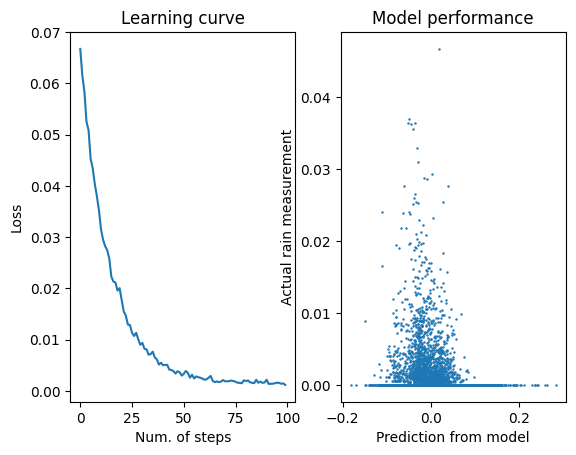

In [ ]:
from google.colab import drive
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


class WeatherDataset(Dataset):
  def __init__(self, train_in, train_out):
        # Initialize data
        self.n_samples = train_in.shape[0]

        # here the first column is the class label, the rest are the features
        self.x_data = train_in # size [n_samples, n_features]
        self.y_data = train_out # size [n_samples, 1]

  # support indexing such that dataset[i] can be used to get i-th sample
  def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

  # we can call len(dataset) to return the size
  def __len__(self):
      return self.n_samples

class LinearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(LinearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize) # a default Linear projection layer with weights A and bias B s.t. y = A*x + b

    def forward(self, x):
        y = self.linear(x)
        return y

def process_csv_allfeatures(filename):
  drive.mount('/content/drive')
  df = pd.read_csv(filename)

  # Filter data and apply normalization
  df = df.dropna()
  datatensor = torch.tensor(df.values[1:,1::].astype(float))
  datatensor = torch.nn.functional.normalize(datatensor)

  # Randomly select 80% of the examples for training,
  # remaining 20% will be for testing
  train, test = torch.utils.data.random_split(datatensor, [0.8, 0.2])
  traindata = torch.stack([t for t in train])
  testdata = torch.stack([t for t in test])

  # We can create separate tensors to input and output to the model
  train_in = torch.cat([traindata[:,0:2], traindata[:,3::]], dim=1)
  test_in = torch.cat([testdata[:,0:2], testdata[:,3::]], dim=1)
  train_out = traindata[:,2].unsqueeze(1) # we will use 3rd column as target prediction
  test_out = testdata[:,2].unsqueeze(1)
  return train_in, train_out, test_in, test_out


def train(model, loss, optimizer, \
          trainingData, \
          learning_rate, steps, batch_size):

  loader = iter(DataLoader(dataset=trainingData, batch_size=batch_size, shuffle=True))

  losses = []; step = 0
  for step in range(0, steps):
    input, target = next(loader)
    optimizer.zero_grad() # reset gradiant value to zero
    model.double()
    output = model(input) # pass input to model
    err = loss(output, target) # compute error between model prediction and target value
    losses.append(err) # store err value to monitor training

    err.backward() # evaluate the gradient
    optimizer.step() # propagate the evaluated gradient to update parameters

    #print('step {}, loss {}'.format(step, err.item()))
  return losses

if __name__ == '__main__':
  dataset = '/content/drive/MyDrive/473-Fall23-Recitation/Fall2023-473-Lab3/NYC_Weather_2016_2022.csv'
  train_in, train_out, test_in, test_out = process_csv_allfeatures(dataset)
  trainingData = WeatherDataset(train_in, train_out)

  learning_rate = 0.01
  steps = 100
  batch_size = 256

  model = LinearRegression(inputSize=8, outputSize=1)
  loss = torch.nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

  losses = train(model, loss, optimizer, trainingData, learning_rate, steps, batch_size)

  plt.subplot(1, 2, 1)
  plt.plot(range(steps), torch.stack(losses).detach())
  plt.title('Learning curve')
  plt.xlabel('Num. of steps')
  plt.ylabel('Loss')

  with torch.no_grad(): # this signal informs torch that further operations will not need the gradient computation
    predictions = model(test_in)
    plt.subplot(1, 2, 2)
    plt.xlabel('Prediction from model')
    plt.ylabel('Actual rain measurement')
    plt.title('Model performance')
    plt.plot(predictions, test_out, 'o', markersize=.75)

Our initial approach to build a linear regression model introduced the concepts of an input and output ranges, and stability of convergence. We saw that a linear model typically fails to refine a specific output range in an application like ours, where the predictions should be in a small range of positive values.

In the next experiment, we explored the behavior of the model and how its performance changed using the new hyper-parameters of batch size and learning rate.

## Experiment 1

Plotting 9 different plots for the model learning curves by ranging the batchsize in range $\{32, 64, 128\}$, and the learning rate in range $\{0.005, 0.01, 0.05\}$. At each time, observe and comment on how the change of hyperparameter affects different properties of the learning curve (e.g. the shape, the smoothness or sharpness).

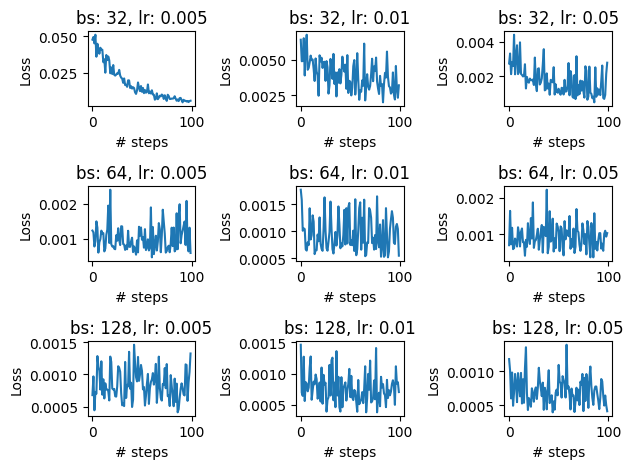

In [ ]:
fig, axs = plt.subplots(3, 3)

def experiment1():

  model = LinearRegression(inputSize=8, outputSize=1)
  loss = torch.nn.MSELoss()
  steps = 100

  for i, batch_size in enumerate([32, 64, 128]):
    for j, learning_rate in enumerate([0.005, 0.01, 0.05]):
      optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
      losses = train(model, loss, optimizer, trainingData, learning_rate, steps, batch_size)

      axs[i][j].plot(range(steps), torch.stack(losses).detach())
      axs[i][j].set_title('bs: {}, lr: {}'.format(batch_size, learning_rate))
      axs[i][j].set_xlabel('# steps')
      axs[i][j].set_ylabel('Loss')


  plt.tight_layout()
  plt.show()

experiment1()


Our first experiment showed in order the model to learn most efficiently from the data we provide, the hyper-parameter values should be carefully tuned. We also saw some values work well together, and some just don't. Empirical findings typically recommend for a large batch size for best stability, and learning rate should be small enough to allow the model learn consistently (and avoid over-fitting) and large enough for the model to reach convergence in reasonable time.

We then explored the affect of the learning objective on the model's ability to learn and perform the desired task efficiently. We changed the loss function to the second loss function we learned in the lecture and repeated our experiment.

Implementing a Python application for rain prediction in New York City using the data set and provided functions for data processing and linear regression which uses the mean absolute error as the loss function. You may use any PyTorch functions.

Mean absolute error is defined as:

$$
 MAE(x, y) = \frac{1}{n} \sum_{i=1}^n |y_i - x_i|
$$

Plot the prediction vs. actual rain measurement plots for the different models.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The absolute mean at each step in training is:  tensor(0.0330, dtype=torch.float64, grad_fn=<MeanBackward0>)


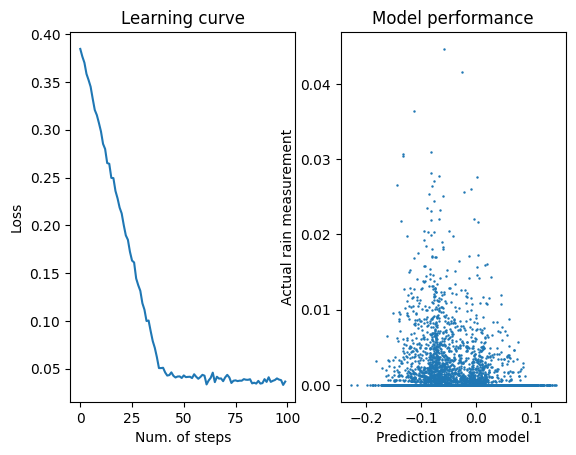

In [ ]:
def experiment2():
  dataset = '/content/drive/MyDrive/473-Fall23-Recitation/Fall2023-473-Lab3/NYC_Weather_2016_2022.csv'
  train_in, train_out, test_in, test_out = process_csv_allfeatures(dataset)
  trainingData = WeatherDataset(train_in, train_out)

  learning_rate = 0.005
  steps = 100
  batch_size = 256

  model = LinearRegression(inputSize=8, outputSize=1)
  loss = torch.nn.L1Loss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

  losses = train(model, loss, optimizer, trainingData, learning_rate, steps, batch_size)
  print("The absolute mean at each step in training is: ", min(losses))

  plt.subplot(1, 2, 1)
  plt.plot(range(steps), torch.stack(losses).detach())
  plt.title('Learning curve')
  plt.xlabel('Num. of steps')
  plt.ylabel('Loss')

  with torch.no_grad(): # this signal informs torch that further operations will not need the gradient computation
    predictions = model(test_in)
    plt.subplot(1, 2, 2)
    plt.xlabel('Prediction from model')
    plt.ylabel('Actual rain measurement')
    plt.title('Model performance')
    plt.plot(predictions, test_out, 'o', markersize=.75)

experiment2()


## Takes from our initial experiments

1. If the model by design does not ensure a restriction on the correct range of outputs, there will be no way for the model to learn that range by itself. It will be our job as machine learning scientists to ensure that the design is consistent with the requirements of the target application from every theoretical and practical sense.
2. Repeated runs of the model may yield unstable results of the experimental settings are non-deterministic.
3. There is no one setting that works for every data set and model. Each model and data set will need its own **specific set of optimal hyper-parameters** to learn from that **specific dataset** using that **specific model**.

Rethinking our pipeline, we'll start by addressing the model design. Theoretically, the range of values of the input $x$ and output $y$ of a linear regression model

$$
  y = A*x + b
$$

is the $\mathbb{R}$.

In our application, the rain measurement values are in the range $[0, 1]$ since we have normalized them. In order to inform the model of this restriction, we can extend the model equation with an additional layer using an **activation function**.

## Logistic function

A typical function that could restrict the range of values produced by a linear projection module is the **logistic** function which takes a range of real values and transforms them into the range of values in $[0, 1]$.

$$
  \sigma (x) = \frac{e^x}{1 + e^x}
$$

(0.0, 1.0)

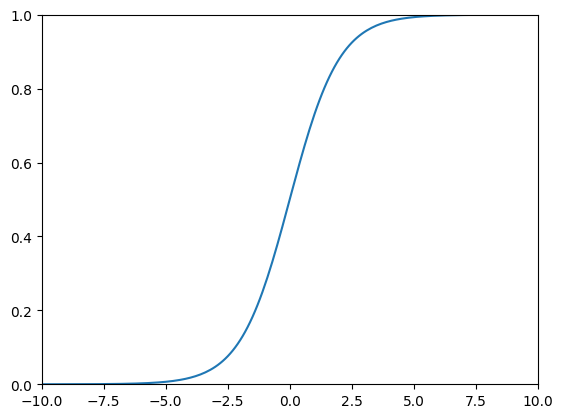

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math

xi = np.arange(-10, 10, 0.1)
y = [ math.exp(x) / (1 + math.exp(x)) for x in xi]

plt.plot(xi, y)
plt.xlim(-10, 10)
plt.ylim(0, 1)


In [ ]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize, bias=True) # a default Linear projection layer with weights A and bias B s.t. y = A*x + b
        self.act = torch.nn.Sigmoid()

    def forward(self, x):
        y = self.linear(x)
        z = self.act(y)
        return z

We can try to test how the output range will now change.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The min. squared error in training is:  tensor(0.0065, dtype=torch.float64, grad_fn=<MseLossBackward0>)


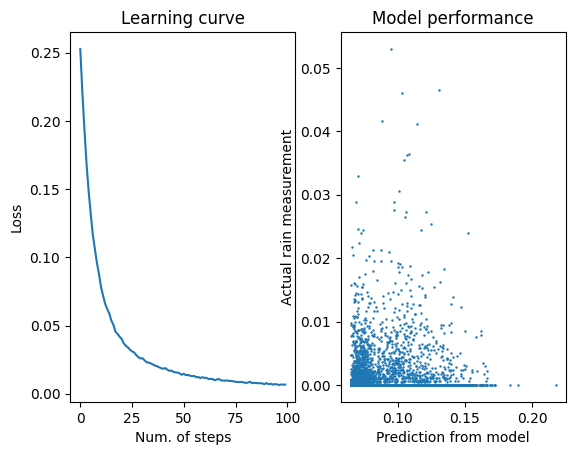

In [ ]:
def experiment3():
  dataset = '/content/drive/MyDrive/473-Fall23-Recitation/Fall2023-473-Lab3/NYC_Weather_2016_2022.csv'
  train_in, train_out, test_in, test_out = process_csv(dataset)
  trainingData = WeatherDataset(train_in, train_out)

  learning_rate = 0.3
  steps = 100
  batch_size = 256

  model = LogisticRegression(inputSize=8, outputSize=1)
  loss = torch.nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

  losses = train(model, loss, optimizer, trainingData, learning_rate, steps, batch_size)
  print("The min. squared error in training is: ", min(losses))


  plt.subplot(1, 2, 1)
  plt.plot(range(steps), torch.stack(losses).detach())
  plt.title('Learning curve')
  plt.xlabel('Num. of steps')
  plt.ylabel('Loss')

  with torch.no_grad(): # this signal informs torch that further operations will not need the gradient computation
    predictions = model(test_in)
    plt.subplot(1, 2, 2)
    plt.xlabel('Prediction from model')
    plt.ylabel('Actual rain measurement')
    plt.title('Model performance')
    plt.plot(predictions, test_out, 'o', markersize=.75)

experiment3()

Note that our model has only 8 input features, thus, an 8x1 $A$ matrix for predicting the linear projection $y = A*x $ weight of each feature. If we wanted to understand how these features are weighted at each prediction, we could try to visualize their values.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/473-Fall23-Recitation/Fall2023-473-Lab3/NYC_Weather_2016_2022.csv')
print(list(df.columns[1:3]) + list(df.columns[4::]))
print(model.linear.weight)

['temperature_2m (°C)', 'precipitation (mm)', 'cloudcover (%)', 'cloudcover_low (%)', 'cloudcover_mid (%)', 'cloudcover_high (%)', 'windspeed_10m (km/h)', 'winddirection_10m (°)']
Parameter containing:
tensor([[-0.1570,  0.1899, -0.0883, -0.2584,  0.1108,  0.2755, -0.0321, -0.2948]],
       dtype=torch.float64, requires_grad=True)


In [ ]:
predictions = torch.where(predictions > 0, 1.0, 0.0)
test_out = torch.where(test_out > 0, 1.0, 0.0)

print("Accuracy of prediction is: ", torch.sum(predictions == test_out)/test_out.shape[0])


Accuracy of prediction is:  tensor(0.6810)



**Accuracy** is the percentage of all correctly classified examples in our test set.  

A more refined analysis can be performed using **the confusion matrix**:
$$
C = \begin{bmatrix}
\text{Predict 0, Actual 0} & \text{Predict 0, Actual 1}\\
\text{Predict 1, Actual 0} & \text{Predict 1, Actual 1}
\end{bmatrix}
$$

Notice that the diagonal entries are the examples that are correctly classified.  

The most useful classification metrics are **Precision** and **Recall**. If we define a prediction $C_{ij}$ which belongs to class i for which we estimated the label i, we calculate them as follows.

#### Precision Score
The precision score is the percentage
$$
\text{Precision}_0 = \frac{C_{00}}{C_{00} + C_{01}}
$$

$$
\text{Precision}_1 = \frac{C_{11}}{C_{11} + C_{10}}
$$
which is the percentage of predicted rain possibility that we classify correctly.  

#### Recall Score
The recall score is the percentage
$$
\textrm{Recall}_0 = \frac{C_{00}}{C_{00} + C_{10}}
$$
$$
\textrm{Recall}_1 = \frac{C_{11}}{C_{11} + C_{01}}
$$
which is the percentage of rain possibility that we classify correctly. Note that Precision and Recall are two different quantities.

**Using multiple evaluation metrics helps give a better picture of how well our classifier is doing.**

Using the different features in the weather measurement data set, I train an individual logistic regression model on each of the individual measurements:
- 'temperature_2m (°C)'
- 'precipitation (mm)'
- 'cloudcover (%)'
- 'windspeed_10m (km/h)'
- 'winddirection_10m (°)'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The min. squared error in training is:  tensor(0.0136, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Accuracy of prediction is:  tensor(0.1357)
Precision:  tensor(0.1357)
Recall:  tensor(1.)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The min. squared error in training is:  tensor(0.0137, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Accuracy of prediction is:  tensor(0.1379)
Precision:  tensor(0.1379)
Recall:  tensor(1.)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The min. squared error in training is:  tensor(0.0115, dtype=torch.float64, grad_fn=<MseLossBackward0>)
Accuracy of prediction is:  tensor(0.1349)
Precision:  tensor(0.1349)
Recall:  tensor(1.)
Drive already mounted at /conte

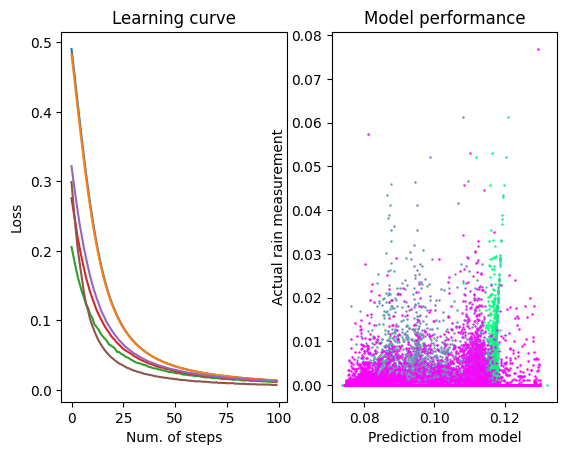

In [ ]:
## Your solution ##

def process_csv_singlefeature(dataset, featureid): # new input sets the column we would like to use as input feature
  ## To-do: Update to return only one-dimensional features
  drive.mount('/content/drive')
  df = pd.read_csv(dataset)

  # Filter data and apply normalization
  df = df.dropna()
  datatensor = torch.tensor(df.values[1:,1::].astype(float))
  datatensor = torch.nn.functional.normalize(datatensor)

  # Randomly select 80% of the examples for training,
  # remaining 20% will be for testing
  train, test = torch.utils.data.random_split(datatensor, [0.8, 0.2])
  traindata = torch.stack([t for t in train])
  testdata = torch.stack([t for t in test])

  # We can create separate tensors to input and output to the model
  train_in = traindata[:,featureid].unsqueeze(1)
  test_in = testdata[:,featureid].unsqueeze(1)
  train_out = traindata[:,2].unsqueeze(1) # we will use 3rd column as target prediction
  test_out = testdata[:,2].unsqueeze(1)
  return train_in, train_out, test_in, test_out


def experiment4():
  dataset = '/content/drive/MyDrive/473-Fall23-Recitation/Fall2023-473-Lab5/NYC_Weather_2016_2022.csv'

  features = [0, 1, 3, 4, 7, 8] # 'temperature_2m (°C)', 'precipitation (mm)', 'cloudcover (%)', 'windspeed_10m (km/h)', 'winddirection_10m (°)'
  for i in features:
    train_in, train_out, test_in, test_out = process_csv_singlefeature(dataset, featureid=i)
    trainingData = WeatherDataset(train_in, train_out)

    learning_rate = 0.3
    steps = 100
    batch_size = 256

    model = LogisticRegression(inputSize=1, outputSize=1)
    loss = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    losses = train(model, loss, optimizer, trainingData, learning_rate, steps, batch_size)
    print("The min. squared error in training is: ", min(losses))

    plt.subplot(1, 2, 1)
    plt.plot(range(steps), torch.stack(losses).detach())
    plt.title('Learning curve')
    plt.xlabel('Num. of steps')
    plt.ylabel('Loss')

    with torch.no_grad(): # this signal informs torch that further operations will not need the gradient computation
      predictions = model(test_in)
      plt.subplot(1, 2, 2)
      plt.xlabel('Prediction from model')
      plt.ylabel('Actual rain measurement')
      plt.title('Model performance')
      plt.plot(predictions, test_out, 'o', markersize=.75, color=(i/8.0, 1-i/8.0, i/16.0+0.5))

    # To-do: Compute accuracy, precision, recall
    predictions = torch.where(predictions > 0, 1.0, 0.0)
    test_out = torch.where(test_out > 0, 1.0, 0.0)

    print("Accuracy of prediction is: ", torch.sum(predictions == test_out)/test_out.shape[0])
    precision = torch.logical_and(predictions, test_out).sum() / (predictions == 1).sum()
    recall = torch.logical_and(predictions, test_out).sum() / (test_out == 1).sum()
    print("Precision: ", precision)
    print("Recall: ", recall)

experiment4()

While the activation functions can help refine the range of target output, the ultimate estimation of the underlying function $y = f(x)$ that helps learn the data distribution depends on the loss function. Least squares may help in many prediction tasks, but for predicting the probability of any future event, we can rely on the **cross-entropy** function.

Cross-entropy essentially measures the similarity between two probability distributions. Here, $y$ represents the underlying function we are trying estimate using the data:

$$\mathcal{L}(x,y) = - ( y \cdot \log(p_{+}) + (1 - y) \cdot \log(1 - p_{+}) )$$

and $p_+$ in our application will represent the predicted probability of observing rain (the positive event) measured using the weather data set.
Note that $p_{+}$ depends on $x$ and the model parameters.


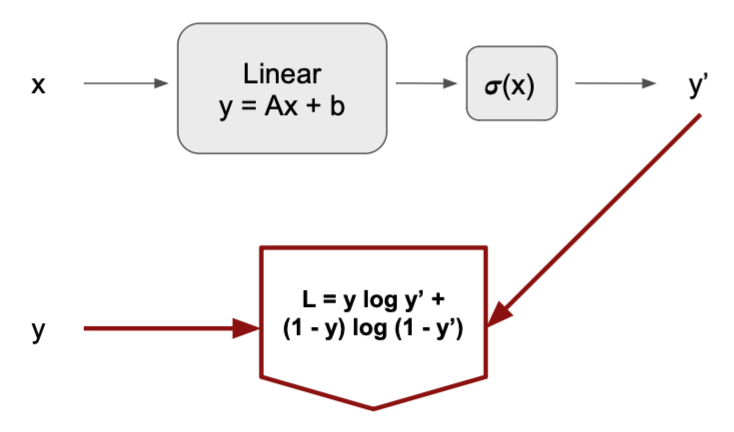


## Binary Cross-entropy

We can now finalize our logistic regression model with the cross-entropy loss. If we want to predict the probability of rain, now we need to change our target data from rain measurement to binary values representing the presence of rain.

In the next exercise, change the loss function to binary cross-entropy and the output labels to binary values. Plot the learning curve and predictions for the model using all features and display the model weights corresponding to each input feature. Repeat the experiment for the models using individual features. Calculate the accuracy, precision and recall at each case.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The min. squared error in training is:  tensor(0.2800, dtype=torch.float64, grad_fn=<BinaryCrossEntropyBackward0>)
The average chance of rain is:  tensor(0.1389, dtype=torch.float64)
Accuracy of prediction is:  tensor(0.6264)
Precision:  tensor(0.2509)
Recall:  tensor(0.9463)


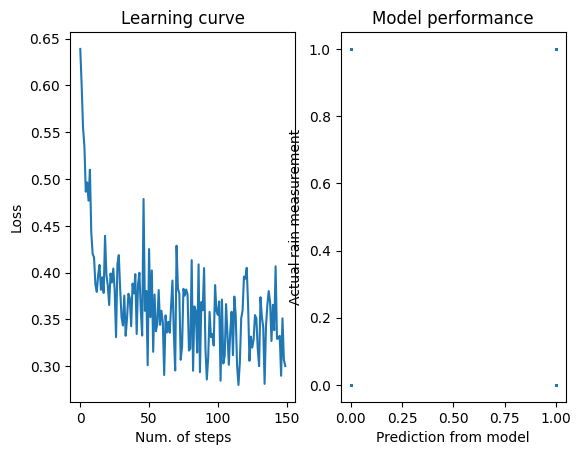

In [ ]:
def experiment5():

  dataset = '/content/drive/MyDrive/473-Fall23-Recitation/Fall2023-473-Lab3/NYC_Weather_2016_2022.csv'
  train_in, train_out, test_in, test_out = process_csv_allfeatures(dataset)
  train_out = (train_out > 0).double()
  test_out = (test_out > 0).double()

  trainingData = WeatherDataset(train_in, train_out)

  learning_rate = 0.3
  steps = 150
  batch_size = 256

  model = LogisticRegression(inputSize=8, outputSize=1)
  loss = torch.nn.BCELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

  losses = train(model, loss, optimizer, trainingData, learning_rate, steps, batch_size)
  print("The loss function at each step in training is: ", min(losses))


  plt.subplot(1, 2, 1)
  plt.plot(range(steps), torch.stack(losses).detach())
  plt.title('Learning curve')
  plt.xlabel('Num. of steps')
  plt.ylabel('Loss')

  with torch.no_grad(): # this signal informs torch that further operations will not need the gradient computation
    model_output = model(test_in)
    print("The average chance of rain is: ", model_output.mean())
    predictions = (model_output > 0.1)
    plt.subplot(1, 2, 2)
    plt.xlabel('Prediction from model')
    plt.ylabel('Actual rain measurement')
    plt.title('Model performance')
    plt.plot(predictions, test_out, 'o', markersize=.75)

    print("Accuracy of prediction is: ", torch.sum(predictions == test_out)/test_out.shape[0])
    precision = torch.logical_and(predictions, test_out).sum() / (predictions == 1).sum()
    recall = torch.logical_and(predictions, test_out).sum() / (test_out == 1).sum()
    print("Precision: ", precision)
    print("Recall: ", recall)

experiment5()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The min. squared error in training is:  tensor(0.3148, dtype=torch.float64, grad_fn=<BinaryCrossEntropyBackward0>)
The average chance of rain is:  tensor(0.1333, dtype=torch.float64)
Accuracy of prediction is:  tensor(0.1370)
Precision:  tensor(0.1370)
Recall:  tensor(1.)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The min. squared error in training is:  tensor(0.2924, dtype=torch.float64, grad_fn=<BinaryCrossEntropyBackward0>)
The average chance of rain is:  tensor(0.1370, dtype=torch.float64)
Accuracy of prediction is:  tensor(0.1331)
Precision:  tensor(0.1331)
Recall:  tensor(1.)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The min. squared error in training is:  tensor(0.3138, dtype=torch.

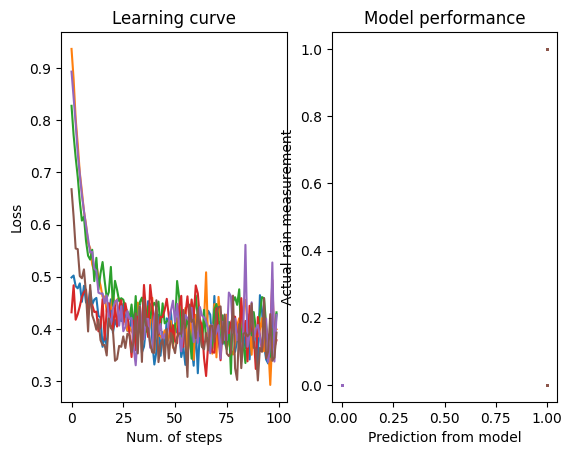

In [ ]:

def experiment6():
  dataset = '/content/drive/MyDrive/473-Fall23-Recitation/Fall2023-473-Lab5/NYC_Weather_2016_2022.csv'

  features = [0, 1, 3, 4, 7, 8] # 'temperature_2m (°C)', 'precipitation (mm)', 'cloudcover (%)', 'windspeed_10m (km/h)', 'winddirection_10m (°)'
  for i in features:
    train_in, train_out, test_in, test_out = process_csv_singlefeature(dataset, featureid=i)
    train_out = (train_out > 0).double()
    test_out = (test_out > 0).double()
    trainingData = WeatherDataset(train_in, train_out)

    learning_rate = 0.3
    steps = 100
    batch_size = 256

    model = LogisticRegression(inputSize=1, outputSize=1)
    loss = torch.nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    losses = train(model, loss, optimizer, trainingData, learning_rate, steps, batch_size)
    print("The min. squared error in training is: ", min(losses))

    plt.subplot(1, 2, 1)
    plt.plot(range(steps), torch.stack(losses).detach())
    plt.title('Learning curve')
    plt.xlabel('Num. of steps')
    plt.ylabel('Loss')

    with torch.no_grad(): # this signal informs torch that further operations will not need the gradient computation
      model_output = model(test_in)
    print("The average chance of rain is: ", model_output.mean())
    predictions = (model_output > 0.1)
    plt.subplot(1, 2, 2)
    plt.xlabel('Prediction from model')
    plt.ylabel('Actual rain measurement')
    plt.title('Model performance')
    plt.plot(predictions, test_out, 'o', markersize=.75)

    print("Accuracy of prediction is: ", torch.sum(predictions == test_out)/test_out.shape[0])
    precision = torch.logical_and(predictions, test_out).sum() / (predictions == 1).sum()
    recall = torch.logical_and(predictions, test_out).sum() / (test_out == 1).sum()
    print("Precision: ", precision)
    print("Recall: ", recall)

experiment6()

## Multi-class classification

In this exercise, we will implement a logistic regression model on multi-class classification. We will use the [Iris](https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-plants-dataset) flower data set which contains different physical properties from three related species of Iris flowers collected by Edgar Anderson. It was first used by British statistician and biologist Ronald Fisher in 1936 for his pioneering study on linear discriminant analysis [1].

<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/5/56/Kosaciec_szczecinkowaty_Iris_setosa.jpg" width="200"/>
<img src="https://upload.wikimedia.org/wikipedia/commons/4/41/Iris_versicolor_3.jpg" width="200" />
  <img src="https://upload.wikimedia.org/wikipedia/commons/9/9f/Iris_virginica.jpg" width="200" />
</div>

*Images from Wikipedia.*

[1] Fisher, R.A. “The use of multiple measurements in taxonomic problems” Annual Eugenics, 7, Part II, 179-188 (1936).

We can load the data set automatically using the [sklearn](https://scikit-learn.org/stable/) library.

In [ ]:
from sklearn.datasets import load_iris
import pandas as pd

iris_data = load_iris()
df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
df['target'] = pd.Series(iris_data.target)

df


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


We can start by doing some analysis. Please write a short analysis code to count how many samples are there from each class of flower. Plot the count as a bar graph.

N = 150 data points


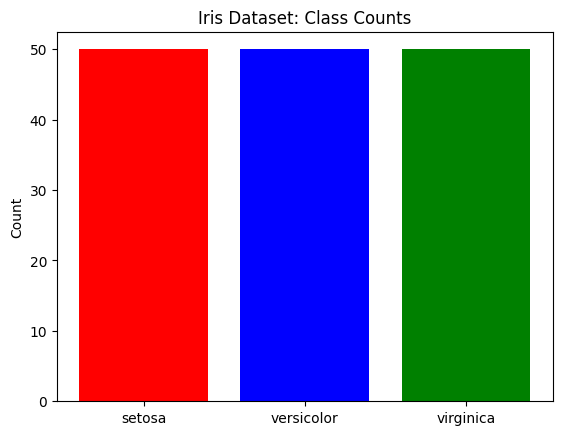

In [ ]:
import matplotlib.pyplot as plt

# Count the number of classes and plot.
N = len(df) # The number of data points.
print('N = {:d} data points'.format(N))

# Give a barplot of each class.
plt.figure()
plt.bar([0,1,2], df['target'].value_counts(ascending = True), color = ['r', 'b', 'g'], tick_label = iris_data.target_names)
plt.ylabel('Count')
plt.title('Iris Dataset: Class Counts');



Next, we will create a training and testing split. Please process the data to convert to tensors and store as training and testing tensors. Make sure the data is numeric and clean. Note that we also need to define the input and output to our classification model.

In [ ]:
import torch

# Write data processing and splitting routine
df = df.dropna()
datatensor = torch.tensor(df.values)

# Randomly select 80% of the examples for training,
# remaining 20% will be for testing
train, test = torch.utils.data.random_split(datatensor, [0.8, 0.2])
traindata = torch.stack([t for t in train])
testdata = torch.stack([t for t in test])

# We can create separate tensors to input and output to the model
train_features = traindata[:,0:4]
test_features = testdata[:,0:4]
train_target = traindata[:,4].unsqueeze(1)
test_target = testdata[:,4]

# In case of multi-class classification we will reorganize the output to 3 dimensions each representing
# the probability of an individual class
train_mc = torch.zeros(train_target.shape[0], 3)
indices = torch.cat([torch.arange(train_target.shape[0]).unsqueeze(1), train_target], dim=1).int()
train_mc = torch.stack([train_mc[i].index_fill_(dim=0, index=train_target[i].long(), value=1) for i in torch.arange(train_target.shape[0])]).double()
print("New format for the training target data: ", train_mc[0:10,:])


New format for the training target data:  tensor([[0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.]], dtype=torch.float64)


Let's define again a PyTorch Dataset type class to store and easily iterate over the Iris Data Set.

In [ ]:
from torch.utils.data import Dataset, DataLoader, RandomSampler

class IrisDataset(Dataset):
  def __init__(self, train_in, train_out):
        # Initialize data
        self.n_samples = train_in.shape[0]
        self.x_data = train_in # size [n_samples, n_features]
        self.y_data = train_out # size [n_samples, 1]

  # support indexing such that dataset[i] can be used to get i-th sample
  def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

  # we can call len(dataset) to return the size
  def __len__(self):
      return self.n_samples

Define a logistic regression model and create a training routine to train the model on the training data. Plot the learning curve. Make sure the training is stable and model converges by tuning the hyperparameters, including the batch size and learning rate.

In [ ]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize, bias=True) # a default Linear projection layer with weights A and bias B s.t. y = A*x + b
        self.act = torch.nn.Sigmoid()

    def forward(self, x):
        y = self.linear(x)
        z = self.act(y)
        return z

The cross-entropy in training is:  tensor(0.4116, dtype=torch.float64, grad_fn=<BinaryCrossEntropyBackward0>)


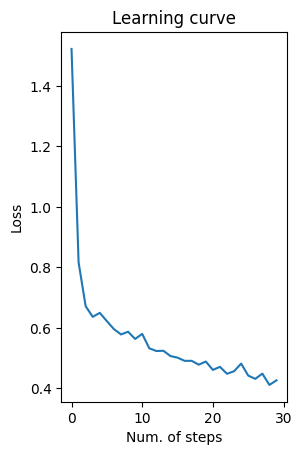

In [ ]:
# Implement the model and create training routine.
def train(model, loss, optimizer, \
          trainingData, \
          learning_rate, steps, batch_size, epochs):


  losses = [];
  for i in range(epochs):
    loader = iter(DataLoader(dataset=trainingData, batch_size=batch_size, shuffle=True))

    for step in range(0, steps):
      input, target = next(loader)
      optimizer.zero_grad() # reset gradiant value to zero
      model.double()
      output = model(input) # pass input to model

      err = loss(output, target)
      losses.append(err) # store err value to monitor training

      err.backward() # evaluate the gradient
      optimizer.step() # propagate the evaluated gradient to update parameters

  return losses

def train_iris_logistic():

  learning_rate = 0.2
  steps = 3
  batch_size = 40
  epochs = 10

  trainingData = IrisDataset(train_features, train_mc)

  iris_model = LogisticRegression(inputSize=4, outputSize=3)
  loss = torch.nn.BCELoss()
  optimizer = torch.optim.SGD(iris_model.parameters(), lr=learning_rate)

  losses = train(iris_model, loss, optimizer, trainingData, learning_rate, steps, batch_size, epochs)
  print("The cross-entropy in training is: ", min(losses))

  losses = torch.stack(losses, dim=0)
  plt.subplot(1, 2, 1)
  plt.plot(range(steps*epochs), losses.detach())
  plt.title('Learning curve')
  plt.xlabel('Num. of steps')
  plt.ylabel('Loss')

  return iris_model

iris_model = train_iris_logistic()

Use the testing set to generate predictions with the model. Calculate the prediction accuracy, precision and recall for each of the three classes.

Predictions:  tensor([2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0,
        2, 2, 2, 2, 0, 2])
Accuracy of prediction is:  tensor(0.7000)
Precision (for class 0):  tensor(1.)
Recall (for class 0):  tensor(1.)
Precision (for class 1):  tensor(nan)
Recall (for class 1):  tensor(0.)
Precision (for class 2):  tensor(0.5909)
Recall (for class 2):  tensor(1.)


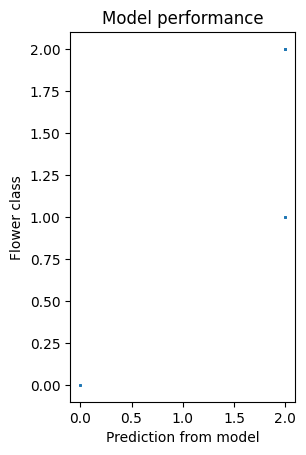

In [ ]:
with torch.no_grad(): # this signal informs torch that further operations will not need the gradient computation
    predictions = iris_model(test_features) # note that outputs now indicate probabilities for each class
    predictions = torch.argmax(predictions, 1)
    print("Predictions: ", predictions)
    plt.subplot(1, 2, 2)
    plt.xlabel('Prediction from model')
    plt.ylabel('Flower class')
    plt.title('Model performance')
    plt.plot(predictions, test_target, 'o', markersize=.75)

    print("Accuracy of prediction is: ", torch.sum(predictions == test_target)/test_target.shape[0])

    # Calculate precision and recall for each class
    precision = torch.logical_and((predictions == 0), (test_target == 0)).sum() / (predictions == 0).sum()
    recall = torch.logical_and((predictions == 0), (test_target == 0)).sum() / (test_target == 0).sum()
    print("Precision (for class 0): ", precision)
    print("Recall (for class 0): ", recall)

    precision = torch.logical_and((predictions == 1), (test_target == 1)).sum() / (predictions == 1).sum()
    recall = torch.logical_and((predictions == 1), (test_target == 1)).sum() / (test_target == 1).sum()
    print("Precision (for class 1): ", precision)
    print("Recall (for class 1): ", recall)

    precision = torch.logical_and((predictions == 2), (test_target == 2)).sum() / (predictions == 2).sum()
    recall = torch.logical_and((predictions == 2), (test_target == 2)).sum() / (test_target == 2).sum()
    print("Precision (for class 2): ", precision)
    print("Recall (for class 2): ", recall)

## Logistic regression with gradient descent from scratch

This exercise aims to strengthen the understanding of the machine learning pipeline. Instead of PyTorch functions for iterative and batch training, we can use our own implementation for weather prediction that passes through the logistic regression model and computes the loss at each time.

We can start with the beginning of the pipeline and use the function for data preparation:

In [ ]:
from google.colab import drive
import pandas as pd
import torch

dataset = '/content/drive/MyDrive/473-Fall23-Recitation/Fall2023-473-Lab3/NYC_Weather_2016_2022.csv'
drive.mount('/content/drive')
df = pd.read_csv(dataset)

# Filter data and apply normalization
df = df.dropna()
datatensor = torch.tensor(df.values[1:,1::].astype(float))
datatensor = torch.nn.functional.normalize(datatensor)

# Change the output to binary format
datatensor[:,2] = torch.where(datatensor[:,2] > 0.0, 1.0, 0.0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


After loading the data set, we can do the train and test split with PyTorch random sampling utility. The **randperm** function will create a permutation of the input ordered indices according to a Uniform probability distribution.

In [ ]:
# 1. Shuffle the data set so original order of measurements are mixed and distributed
idx = torch.randperm(datatensor.shape[0])
datatensor_shuffled = datatensor[idx]

# 2. Find splitting point to separate training and testing data
len_traindata = int(datatensor.shape[0]*0.8)

traindata = datatensor_shuffled[0:len_traindata,:]
testdata = datatensor_shuffled[len_traindata::,:]

print("Train data has samples of size: ", traindata.shape)
print("Test data has samples of size: ", testdata.shape)

# 3. To-do: Extract input features (Columns 0, 1, 3, .., 8) and store in train_in
train_in = torch.cat([traindata[:,0:2], traindata[:,3::]], dim=1)
test_in = torch.cat([testdata[:,0:2], testdata[:,3::]], dim=1)
train_out = traindata[:,2] # we will use 3rd column as target prediction
test_out = testdata[:,2]


Train data has samples of size:  torch.Size([47668, 9])
Test data has samples of size:  torch.Size([11918, 9])


We will learn the optimal values for the parameters in our logistic function using the gradient descent algorithm. In order to complete the optimization, we need to compute the gradient of the function representing the model over the training examples.

Let's create a loop over which we will evaluate the gradient of the model on the examples and use the gradient value to update our parameters.

At each step, complete the missing parts using Python or PyTorch for mathematical functions and ensure all four steps of training are consistent. Check if you can train your model using gradient-descent.

In [ ]:
# Training loop without any Pytorch functions

# Training hyper-parameters
learning_rate = 0.01
steps = 100

# Initialize model parameters
NEAR_ZERO = 1e-12
w = torch.zeros(8, 1, dtype=torch.double)
b = torch.scalar_tensor(0)

for i in range(steps):

  # 1: Forward function of the logistic regression model
  # y = sigmoid (train_in @ w + b )
  y = torch.sigmoid(train_in @ w + b)
  print(y.shape)
  # 2: Implement gradient descent over loss function
  # Note: there are two sets of parameters: w and b
  # That will be updated individually with dw and db
  # We can call them dw and db

  num_samples = train_in.shape[0] # batch_size
  dw = (1 / num_samples) * (train_in * (y - train_out)).sum(dim=0)
  db = (1 / num_samples) * torch.sum(y - train_out)


  # 3: Update parameter values using db and dw
  w -= w + learning_rate * dw
  b -= b + learning_rate * db


torch.Size([47668, 1])


Once we complete the training, we can use the model that learned to predict the rain for actual measurement:

In [1]:
import matplotlib.pyplot as plt

# Use trained model to predict rain probability
predictions = torch.sigmoid(test_in @ w + b)
print("The average chance of rain is: ", predictions.mean())
predictions = (predictions > 0.1)
plt.subplot(1, 2, 2)
plt.xlabel('Prediction from model')
plt.ylabel('Actual rain measurement')
plt.title('Model performance')
plt.plot(predictions, test_out, 'o', markersize=.75)

print("Accuracy of prediction is: ", torch.sum(predictions == test_out)/test_out.shape[0])
precision = torch.logical_and(predictions, test_out).sum() / (predictions == 1).sum()
recall = torch.logical_and(predictions, test_out).sum() / (test_out == 1).sum()
print("Precision: ", precision)
print("Recall: ", recall)



NameError: ignored